# Introduction

Implementing kernels designed in Automatic forecasting using Gaussian Process [1] and test results with the M4 dataset. For now, only small sections of the M4 training and testing datasets are being used.



In [1]:
# Get this to work on GPUs.
from pandas.core.groupby.generic import DataFrameGroupBy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
!pip install gpytorch # This is to allow gpytorch to work on any Google Colab Notebook
import gpytorch as gp
import random

  Using cached gpytorch-1.8.1-py2.py3-none-any.whl (361 kB)


Setting up the full m4 dataset and any subsets (ex. monthly, weekly, hourly, etc.) that might be analyzed.

In [2]:
random.seed(0)
df = pd.read_csv('M4-info.csv') # This is for the m4 dataset as a whole
df_test = pd.read_csv("Monthly-test.csv") # Monthly dataset for testing purposes
df_train = pd.read_csv("Monthly-train.csv") # Monthly dataset for training purposes

## Setting a new dataset with one row from the training dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the training dataset.


In [3]:
df_2 = df_train.loc[2574].to_frame() # This is a dataframe housing the row that I chose, which I believe is the one with the most elements.
df_2 = df_2.dropna()
df_2 = pd.DataFrame(df_2) # Just confirming that we made a new dataframe
df_2["index"] = df_2.index # There are the indexes corresponding to each element
items = df_2.iloc[:, 0]
df_2 = df_2.assign(items=items)
df_2 = df_2.drop("V1")
df_2['index'] = df_2['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
df_2

,2574,index,items
V2,4200.0,2,4200.0
V3,4218.0,3,4218.0
V4,4200.0,4,4200.0
V5,4200.0,5,4200.0
V6,4221.0,6,4221.0
...,...,...,...
V1850,12655.0,1850,12655.0
V1851,12324.0,1851,12324.0
V1852,12386.0,1852,12386.0
V1853,12260.0,1853,12260.0


Text(0, 0.5, 'Value')

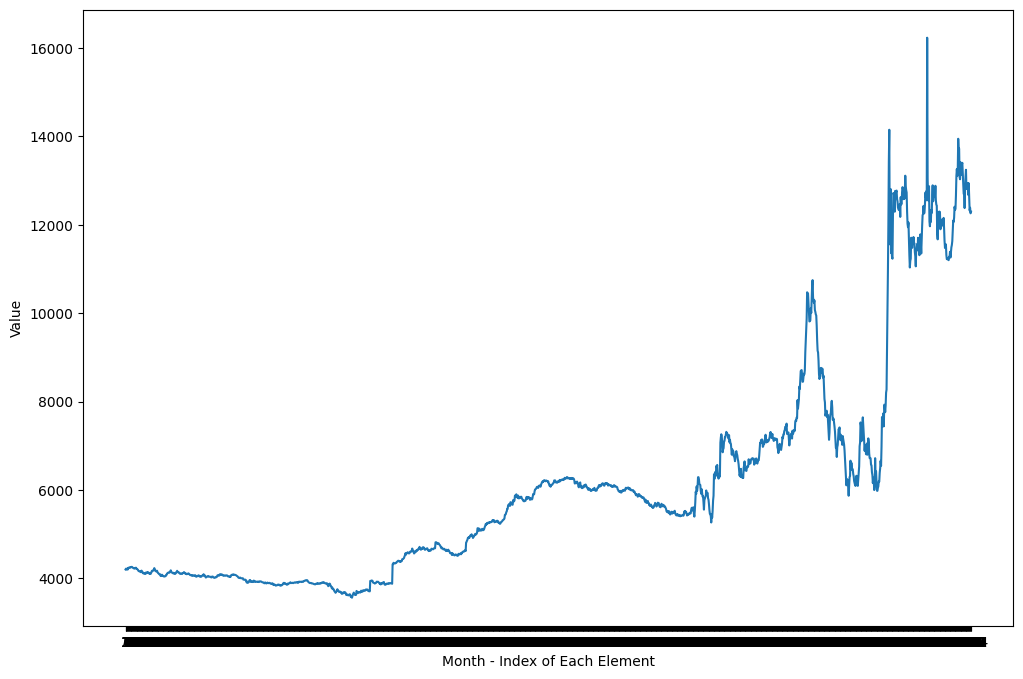

In [4]:
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_2) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

## Plotting the auto-correlation
We plot the auto correlcation function below.

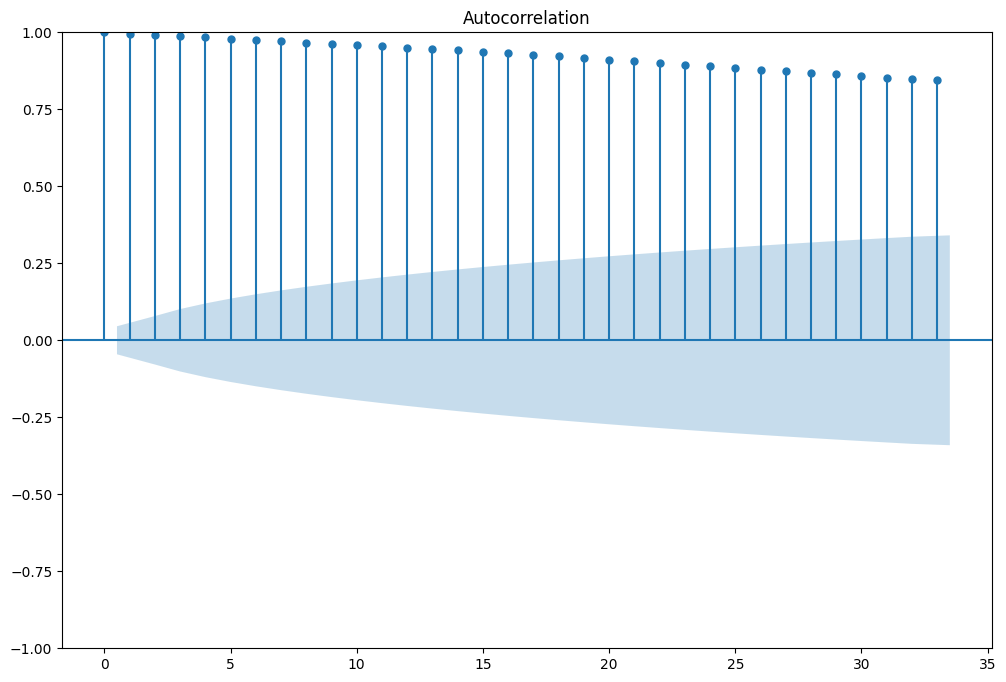

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(df_2['items'])

## Setting a new dataset with one row from the testing dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the testing dataset.


In [6]:
df_3 = df_test.loc[2574].to_frame() # This is a dataframe housing the row that I chose.
df_3 = df_3.dropna()
df_3 = pd.DataFrame(df_3) # Just confirming that we made a new dataframe
df_3["index"] = df_3.index # There are the indexes corresponding to each element
items = df_3.iloc[:, 0]
df_3 = df_3.assign(items=items)
df_3 = df_3.drop("V1")
df_3['index'] = df_3['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
j = 1854
for i in range(len(df_3['index'])): # This makes the indecies of the testing dataset to be after the training set's indecies.
  df_3['index'][i] = j
  j = j + 1

Text(0, 0.5, 'Value')

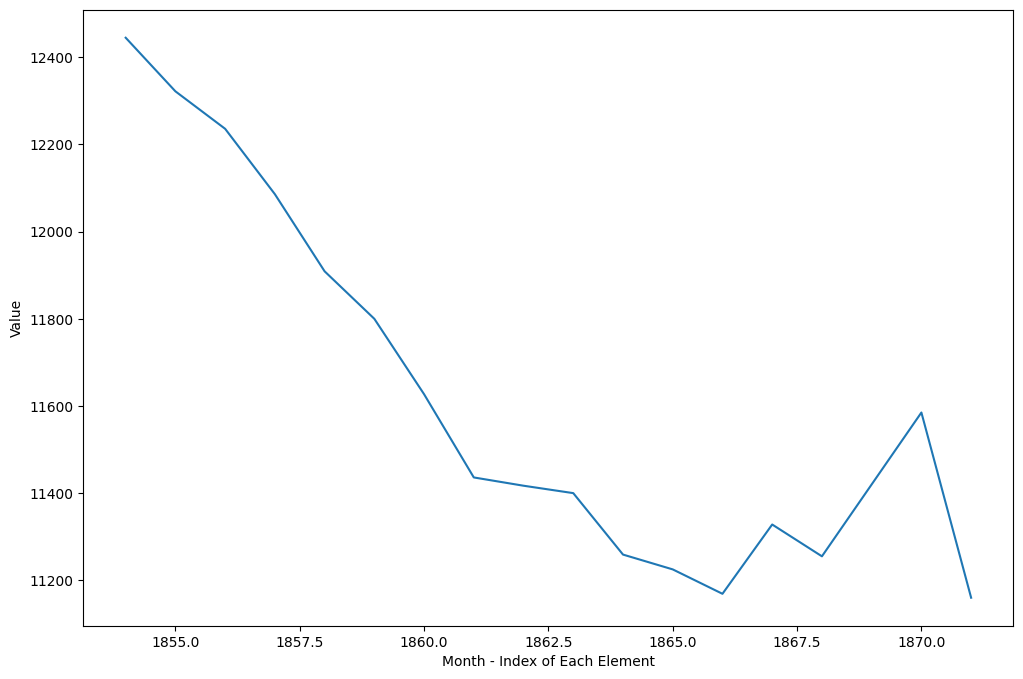

In [7]:
# This is for the testing dataset
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_3) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

In [8]:
# This is the dataset that combines both of the other datasets for testing and training.

df_4 = df_2.append(df_3, ignore_index=True)

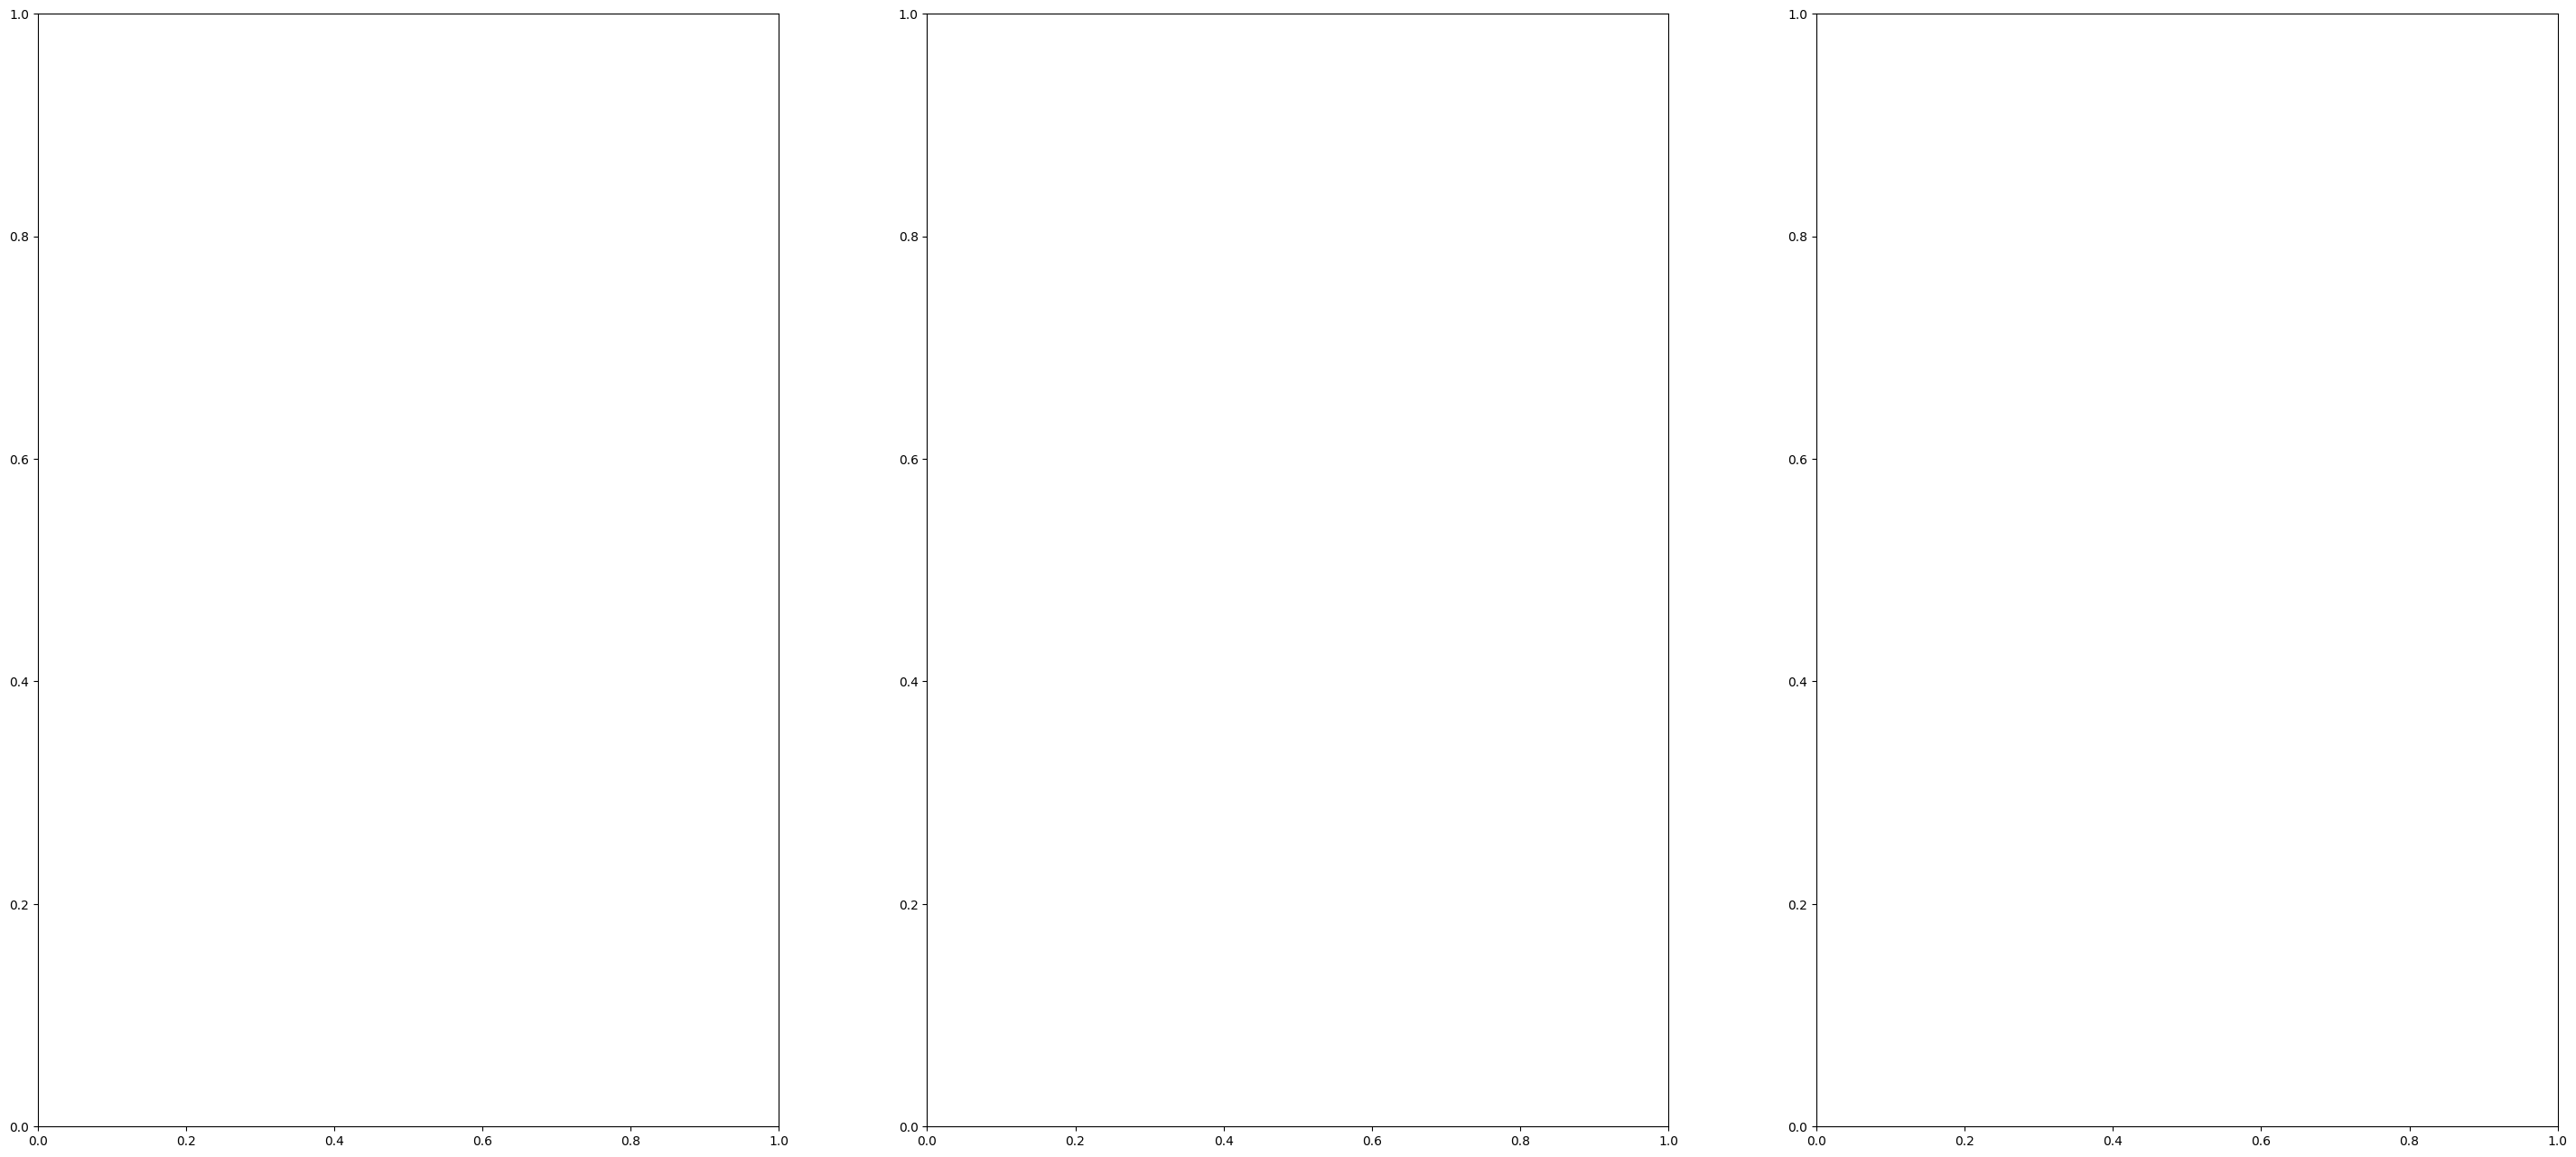

In [9]:

# Setting up the combined figure for the zoomed out results
fig, axs = plt.subplots(1, 3, figsize=(36, 16))
# Change to 3, 1 for vertical
# Change to 8, 18 for vertical


In [10]:
'''
# Setting up the combined figure for the zoomed-in visuals.
fig, axs = plt.subplots(figsize=(12, 6))
'''

'\n# Setting up the combined figure for the zoomed-in visuals.\nfig, axs = plt.subplots(figsize=(12, 6))\n'

## **Data Testing - Basic**
We prepare the training set and test set data and work with using basic GPs. The data needs to be converted to tensors to work, so some precision of the data is lost. The data is converted to int32 tensors.

In [11]:
# Normalizing df_2 and df_3

# Assigning x_train, y_train, x_test, and y_test
x_train = df_2["index"] # Months
x_train = torch.from_numpy(x_train.values.astype(np.float32))

y_train = df_2["items"] # Values
y_train = torch.from_numpy(y_train.values.astype(np.float32))

x_test = df_3["index"] # Months
x_test = torch.from_numpy(x_test.values.astype(np.float32))

y_test = df_3["items"] # Values
y_test = torch.from_numpy(y_test.values.astype(np.float32))

# Normalize x_train and x_test
x_mean = x_train.mean()
x_std = x_train.std()
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Normalize y_train and y_test
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std


In [12]:
# Using the tutorial code for the simplified testing and training with the dataset.
# Will need to change the GPModel being used as needed.

# Fit the right side of the data at the change in the training graph. See sharp turn.
class GPModel(gp.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood): # Need to add ,device for this line if needed
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.RQKernel()) # Most effective of the combinations I tried, but by the 100th test, the negative LL is still 3023.869.
        # self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.LinearKernel() * gp.kernels.PeriodicKernel()) - This gives low initial losses, but they increase once we go past the 50th round.
        # self.covar_module.initialize_from_data(x_train.type(torch.float32), y_train.type(torch.float32)) # Only for the SpectralMixture Kernel
        # self.device = device
  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gp.distributions.MultivariateNormal(mean_x, covar_x)

'''
  def train(self, device="cpu"):
    super().train()

    # Check if GPU is available
    if torch.cuda.is_available():
        if device == "cuda":
            self.device = torch.device("cuda")
            print("Using GPU")
        else:
            self.device = torch.device("cpu")
            print("Using CPU")

    self.to(self.device)
'''



likelihood = gp.likelihoods.GaussianLikelihood()
# model = GPModel(x_train, y_train, likelihood, "cuda")
model = GPModel(x_train, y_train, likelihood)

In [13]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 1000 # else __ of training iterations
# 10000 iterations so as not to waste usage time on the GCP notebook.
# 1000 would be the most ideal, but even 500 would work to get similar results.

# Need to discuss how to set-up GPU utilization for faster training times, if needed.
'''
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("Using CPU")
'''
# Finding the optimal parameters for the model
# model.train(device="cuda")
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

Iter 1/1000 - Loss: 0.793
Iter 2/1000 - Loss: 0.756
Iter 3/1000 - Loss: 0.718
Iter 4/1000 - Loss: 0.684
Iter 5/1000 - Loss: 0.646
Iter 6/1000 - Loss: 0.612
Iter 7/1000 - Loss: 0.570
Iter 8/1000 - Loss: 0.532
Iter 9/1000 - Loss: 0.492
Iter 10/1000 - Loss: 0.456
Iter 11/1000 - Loss: 0.411
Iter 12/1000 - Loss: 0.371
Iter 13/1000 - Loss: 0.333
Iter 14/1000 - Loss: 0.283
Iter 15/1000 - Loss: 0.248
Iter 16/1000 - Loss: 0.203
Iter 17/1000 - Loss: 0.160
Iter 18/1000 - Loss: 0.111
Iter 19/1000 - Loss: 0.070
Iter 20/1000 - Loss: 0.033
Iter 21/1000 - Loss: -0.015
Iter 22/1000 - Loss: -0.056
Iter 23/1000 - Loss: -0.094
Iter 24/1000 - Loss: -0.143
Iter 25/1000 - Loss: -0.199
Iter 26/1000 - Loss: -0.231
Iter 27/1000 - Loss: -0.267
Iter 28/1000 - Loss: -0.318
Iter 29/1000 - Loss: -0.367
Iter 30/1000 - Loss: -0.398
Iter 31/1000 - Loss: -0.455
Iter 32/1000 - Loss: -0.477
Iter 33/1000 - Loss: -0.502
Iter 34/1000 - Loss: -0.536
Iter 35/1000 - Loss: -0.582
Iter 36/1000 - Loss: -0.608
Iter 37/1000 - Loss: 

/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


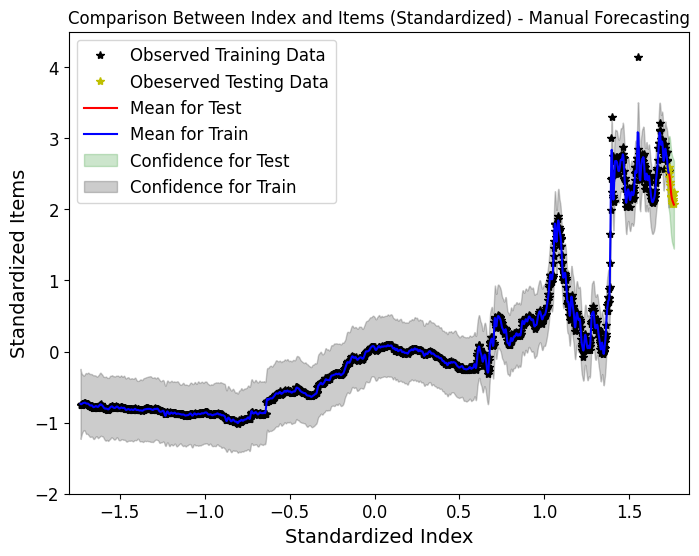

In [14]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

# Check to see if the model fits by changing the test and training sizes. Start with 100% train to see if there the gap is still present.
model.eval()
likelihood.eval()
# Concatenate x_train and x_test together. 
with torch.no_grad(), gp.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(x_train))
    pred_test = likelihood(model(x_test))

    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([x_train, x_test], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gp.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(x_train)]  # Variances for training data
    test_var = pred_all.variance[len(x_train):]   # Variances for test data


    # Initializing the plot
    fig1, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(x_test.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(x_train.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    
    ax.set_ylim([-2, 4.5])
    ax.set_xlim([-1.8, 1.85])
    
    #ax.set_ylim([1.35, 3.6])
    #ax.set_xlim([1.65, 1.77])
    
    
    # Adding a title to the graph
    ax.set_title('Comparison Between Index and Items (Standardized) - Manual Forecasting')

    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)

    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)
    plt.show()



In [15]:

# Subplot 1 (zoomed out)
axs[0].plot(x_train.numpy(), y_train.numpy(), 'k*')
axs[0].plot(x_test.numpy(), y_test.numpy(), 'y*')
axs[0].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')
axs[0].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')
lower, upper = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()
axs[0].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[0].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[0].set_ylim([-2, 4.5])
#axs[0].set_xlim([-1.8, 1.85])
axs[0].set_xlim([0, 1.75])
# axs[0].set_xticklabels([])
axs[0].set_xlabel('Standardized Index', fontsize=40)
axs[0].set_ylabel('Standardized Items', fontsize=40)
axs[0].set_title('Manual Forecasting', fontsize=42)


Text(0.5, 1.0, 'Manual Forecasting')

In [16]:
'''
# Subplot 1: Manual Forecasting (zoomed in)
lower_1, upper_1 = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()

axs.plot(x_train.numpy(), y_train.numpy(), 'k*')
axs.plot(x_test.numpy(), y_test.numpy(), 'y*')
x_combined = torch.cat([x_test, x_train], dim=0)
mean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)
axs.plot(x_combined.numpy(), mean_combined.numpy(), 'c')
#axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'c')
#axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'c')
axs.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs.fill_between(x_train.numpy(), lower_1.numpy(), upper_1.numpy(), alpha=0.2, color='black')
'''

"\n# Subplot 1: Manual Forecasting (zoomed in)\nlower_1, upper_1 = pred_train.confidence_region()\nlower_2, upper_2 = pred_test.confidence_region()\n\naxs.plot(x_train.numpy(), y_train.numpy(), 'k*')\naxs.plot(x_test.numpy(), y_test.numpy(), 'y*')\nx_combined = torch.cat([x_test, x_train], dim=0)\nmean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)\naxs.plot(x_combined.numpy(), mean_combined.numpy(), 'c')\n#axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'c')\n#axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'c')\naxs.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')\naxs.fill_between(x_train.numpy(), lower_1.numpy(), upper_1.numpy(), alpha=0.2, color='black')\n"

# Evaluation for Basic Testing
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [17]:
!pip install git+https://github.com/jpchen/autoforecasting.git
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-q7qaulcm
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-q7qaulcm
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done
  Created wheel for timeseries: filename=timeseries-0.0.0-py3-none-any.whl size=42057 sha256=b577e26d3070d9cd06df51ff34ebfcdc7718803d4b45889c600183629b502e39
  Stored in directory: /tmp/pip-ephem-wheel-cache-dy0c3edv/wheels/6b/16/5a/3645e1c96e982a34fcd4a5ff36ce5e504cdcf7f8e4cf8e97fa
Successfully built timeseries


Here we compute MAE for both training data and test data.

In [18]:
from sts.metrics import MAE
MAE_train = MAE(y_train, pred_train.mean).item()
MAE_test = MAE(y_test, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.018
Mean absolute error for test set is: 0.055


Here we compute CRPS for both training data and test data.

In [19]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 03:50:41--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.719’

metrics.py.719      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 03:50:41 (38.4 MB/s) - ‘metrics.py.719’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.054
Continuous ranked probability score for test set is: 0.074


Here we compute log-likelihood for both training data and test data.



In [20]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: 0.603
Log-likelihood for test set is: 0.311


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [21]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.017699,0.053637,0.602641
1,0.055436,0.074453,0.311235



The provided table displays the metric values, with the first line representing the training set and the second line representing the test set. It's worth noting that lower values are preferable for MAE and CRPS, while higher values are desired for LL.

Upon closer examination, we have observed that the training set exhibits higher accuracy compared to the test set. To address this issue and enhance overall performance, we propose implementing a solution that involves assigning priors to the hyperparameters. Additionally, we will leverage hierarchical priors to capitalize on the joint information present in the univariate time series data.

By incorporating these priors into our model, we aim to optimize its performance and reduce the disparity between the accuracy of the training and test sets. This approach will allow us to better capture the underlying patterns and relationships within the data, ultimately improving the model's predictive capabilities.

## **Data Testing - Autoforecasting**
We prepare the training set and test set data and work with using non-standard GPs.
Before that, we need to bring in some classes and modify them to work with my changes.

In [22]:
# Setting up versions of x_train, y_train, etc. to work with the ExactGPAdditiveModel
from sts.data import df_to_tensor
df_4 = df_4.drop(columns=[2574])
df_4_float = df_4.astype('float32') # All issues with data fixed here, but the categories are still present (not a tensor).
df_4 = df_to_tensor(df_4_float, normalize_cols=True) # Now a tensor

In [23]:
print(type(df_4_float))

<class 'pandas.core.frame.DataFrame'>


In [24]:
from sts.data import DataTensor
# For training data
x_train = df_4[:1853, ['index']]
y_train = df_4[:1853, ['items']]

x_test = df_4[1853:, ['index']]
y_test = df_4[1853:, ['items']]

In [25]:
!pip install git+https://github.com/jpchen/autoforecasting.git

  Cloning https://github.com/jpchen/autoforecasting.git to /tmp/pip-req-build-e4j6hht9
  Running command git clone --filter=blob:none --quiet https://github.com/jpchen/autoforecasting.git /tmp/pip-req-build-e4j6hht9
  Resolved https://github.com/jpchen/autoforecasting.git to commit f07246ce45673579f364939f6d1469c33b202a6b
  Preparing metadata (setup.py) ... done


In [26]:
x_train.tensor = x_train.tensor.squeeze(-1)
y_train.tensor = y_train.tensor.squeeze(-1)
x_test.tensor = x_test.tensor.squeeze(-1)
y_test.tensor = y_test.tensor.squeeze(-1)

In [27]:
from sts.gp.model import ExactGPAdditiveModel 
from gpytorch.kernels import LinearKernel, RBFKernel

likelihood = gp.likelihoods.GaussianLikelihood()
# Turn off the standardizing column parameter.

model = ExactGPAdditiveModel(x_train, y_train, likelihood) # This model requires two DataTensors, unlike the other model. 
model.cov.add_trend(
    time_axis="index", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="index",
    kernel_cls=RBFKernel,
    lengthscale=100,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="index",
    num_mixtures=2,
    train_x=x_train,
    train_y=y_train,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="index",
    num_mixtures=2,
    train_x=x_train,
    train_y=y_train,
    name="SM2",
) 

# Create a second RBF kernel for this one and experiment with their number as needed. Do it for this one. 


# Training loop
We train our model with our training set, and show the training time below.

In [28]:
# Fix the time issue, which is because NormalizeCols is off.

learning_rate = 0.01
num_epochs = 1000 # Adjust as needed. Keep it lower until finalized.
# 1000 is a reasonable amount, as this model is quite slow at training.

trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(x_train, y_train)
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()


epoch 1/1000, loss 0.8882236480712891
epoch 2/1000, loss 0.866047739982605
epoch 3/1000, loss 0.8799644112586975
epoch 4/1000, loss 0.8741136789321899
epoch 5/1000, loss 0.8650522828102112
epoch 6/1000, loss 0.8646360039710999
epoch 7/1000, loss 0.8631554245948792
epoch 8/1000, loss 0.852209210395813
epoch 9/1000, loss 0.8506253957748413
epoch 10/1000, loss 0.8539817333221436
epoch 11/1000, loss 0.844677746295929
epoch 12/1000, loss 0.8495036959648132
epoch 13/1000, loss 0.8421512842178345
epoch 14/1000, loss 0.8222475647926331
epoch 15/1000, loss 0.8297893404960632
epoch 16/1000, loss 0.8330660462379456
epoch 17/1000, loss 0.8112744092941284
epoch 18/1000, loss 0.8217854499816895
epoch 19/1000, loss 0.8200714588165283
epoch 20/1000, loss 0.8102504014968872
epoch 21/1000, loss 0.806268036365509
epoch 22/1000, loss 0.8041403889656067
epoch 23/1000, loss 0.7938598990440369
epoch 24/1000, loss 0.7935976386070251
epoch 25/1000, loss 0.7935116291046143
epoch 26/1000, loss 0.7859293818473816

# Predictions
We use our model to forecast the test set.



/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


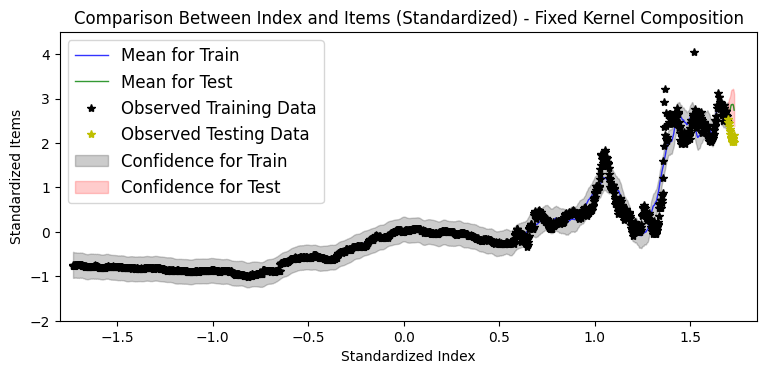

In [29]:
# Calculate GP predictions and statistics
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))

# Create a figure and axis for the plot
fig2, ax = plt.subplots(1, 1, figsize=(9, 3.75))

# Plot the training and test mean values
ax.plot(x_train.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) 
ax.plot(x_test.tensor, test_mean, alpha=0.8, color='green', linewidth=1)

#df_4_float['index'][1853:]
# Plot the actual data points
# ax.plot(x_train.tensor, y_train.tensor, 'o', markersize=1, color='black', label='actual')
ax.plot(x_train.tensor, y_train.tensor, 'k*')
ax.plot(x_test.tensor, y_test.tensor, 'y*')

# Fill the area between confidence intervals
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([x_train, x_test])
ax.fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='black')
ax.fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='red')

# Add labels, title, and legend
ax.set_xlabel('Standardized Index')
ax.set_ylabel('Standardized Items')
ax.set_title('Comparison Between Index and Items (Standardized) - Fixed Kernel Composition')
ax.legend(['Mean for Train', 'Mean for Test', 'Observed Training Data', 'Observed Testing Data', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)


#ax.set_ylim([2, 3.2])
#ax.set_xlim([1.65, 1.73])

ax.set_ylim([-2, 4.5])
ax.set_xlim([-1.8, 1.85])

# Show the plot
plt.show()


The training set has tight credible intervals, while that of the test set is wider. This makes sense since the credible interval gets larger if we extrapolate from the data. But still, we would like to see better performance in the forecasting part.


In [30]:

# Subplot 2 (zoomed out)
axs[1].plot(x_train.tensor, train_mean, alpha=0.8, color='blue', linewidth=1) 
axs[1].plot(x_test.tensor, test_mean, alpha=0.8, color='red', linewidth=1)
axs[1].plot(x_train.tensor, y_train.tensor, 'k*')
axs[1].plot(x_test.tensor, y_test.tensor, 'y*')
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x = torch.cat([x_train, x_test])
axs[1].fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='black')
axs[1].fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='green')
axs[1].set_ylim([-2, 4.5])
#axs[1].set_xlim([-1.8, 1.85])
axs[1].set_xlim([0, 1.75])
#axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Standardized Index', fontsize=40)
# axs[1].set_ylabel('Standardized Items', fontsize = 14)
axs[1].set_title('Fixed Kernel Composition', fontsize=42)


Text(0.5, 1.0, 'Fixed Kernel Composition')

In [31]:
'''
# Subplot 2: Fixed Kernel Composition (zoomed in)
ci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])
x_combined = torch.cat([x_test.tensor, x_train.tensor], dim=0)
mean_combined = torch.cat([test_mean, train_mean], dim=0)
axs.plot(x_combined.numpy(), mean_combined.numpy(), 'magenta', alpha=0.8, linewidth=1)
#axs.plot(x_train.tensor, train_mean, alpha=0.8, color='magenta', linewidth=1) 
#axs.plot(x_test.tensor, test_mean, alpha=0.8, color='magenta', linewidth=1)
#axs.plot(x_train.tensor, y_train.tensor, 'k*')
#axs.plot(x_test.tensor, y_test.tensor, 'y*')
axs.fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='yellow')
axs.fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='blue')
'''

"\n# Subplot 2: Fixed Kernel Composition (zoomed in)\nci_values = torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]])\nx_combined = torch.cat([x_test.tensor, x_train.tensor], dim=0)\nmean_combined = torch.cat([test_mean, train_mean], dim=0)\naxs.plot(x_combined.numpy(), mean_combined.numpy(), 'magenta', alpha=0.8, linewidth=1)\n#axs.plot(x_train.tensor, train_mean, alpha=0.8, color='magenta', linewidth=1) \n#axs.plot(x_test.tensor, test_mean, alpha=0.8, color='magenta', linewidth=1)\n#axs.plot(x_train.tensor, y_train.tensor, 'k*')\n#axs.plot(x_test.tensor, y_test.tensor, 'y*')\naxs.fill_between(x_train, train_ci[0], train_ci[1], alpha=0.2, color='yellow')\naxs.fill_between(x_test, test_ci[0], test_ci[1], alpha=0.2, color='blue')\n"

# Evaluation
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [32]:
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))

# Needed to make sure the data works with the below test code that I had already modified to work with the manual kernel-fitting part.
x_train = x_train.tensor
y_train = y_train.tensor
x_test = x_test.tensor
y_test = y_test.tensor
pred_train = train_mean
pred_test = test_mean

Here we compute MAE for both training data and test data.

In [33]:
from sts.metrics import MAE
# train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
# test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))
# For the above two lines, the error lies in the .predict() function, which does not seem to exist anymore. 

MAE_train = MAE(y_train, pred_train).item()
MAE_test = MAE(y_test, pred_test).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.083
Mean absolute error for test set is: 0.581


Here we compute CRPS for both training data and test data.

In [34]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 04:00:49--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.720’

metrics.py.720      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 04:00:49 (36.0 MB/s) - ‘metrics.py.720’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.080
Continuous ranked probability score for test set is: 0.476


Here we compute log-likelihood for both training data and test data.



In [35]:

from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')


Log-likelihood for training set is: 0.859
Log-likelihood for test set is: 0.694


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [36]:

scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure


,MAE,CPRS,LL
0,0.082951,0.080492,0.85872
1,0.580686,0.475638,0.69419


Above is the table showing the values of each metrics, where the first line is for the training set and the second line is for the test set. As a kind reminder, MAE and CRPS are better if they are lower, while LL is better when it's higher.


At the same time, we noticed the training set shows higher accuracy than the test set. To improve this, we will assign priors to the hyperparameters and use the hierarchical priors to gain joint information of univarite time series.

# Autoforecasting with Changepoint Detection.
We implement automated time series forecasting using advanced techniques, with a focus on changepoint detection. We explore how to identify and incorporate changepoints in time series data to improve the accuracy of our forecasts. 

In [37]:
from sts.changepoints import BinSegChangepoint
binseg = BinSegChangepoint()
changepoints = binseg.get_changepoints(x_train, y_train) #x_train and y_train should be tensors for this line.
# create kernel
from sts.gp.cov import ChangePoint
from sts.gp.cov import Trend

# Reformatting training and testing data.
train_data = df_4[:1853]
test_data = df_4[1853:]

#RBF Kernels
rbf_kernel1 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel2 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)
rbf_kernel3 = Trend(train_data, "index", kernel=RBFKernel, lengthscale=1.0, fix_lengthscale=True)

# Creating a list of the RBF kernels to use for the changepoint
rbf_kernels = [rbf_kernel1, rbf_kernel2, rbf_kernel3]

# ChangePoint Kernel
cp_kernel = ChangePoint(
                    train_data,
                    "index",
                    rbf_kernels,
                    changepoint_location=changepoints,
                    changepoint_steep=1.0,
                    fix_changepoint_location=True,
                    fix_changepoint_steep=True,
                    name="Changepoint - RBF",
                )

model.cov.append(cp_kernel) # Adding to your model.

In [38]:
import os
smoke_test = ("CI" in os.environ)
training_iter = 1000

# Finding the optimal parameters for the model
model = GPModel(x_train, y_train, likelihood)
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1) # Change the learning rate as needed. Lower should be better.

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

def training():
    for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
      optimizer.step()
        
%time training()

Iter 1/1000 - Loss: -0.593
Iter 2/1000 - Loss: -0.653
Iter 3/1000 - Loss: -0.692
Iter 4/1000 - Loss: -0.714
Iter 5/1000 - Loss: -0.739
Iter 6/1000 - Loss: -0.730
Iter 7/1000 - Loss: -0.749
Iter 8/1000 - Loss: -0.758
Iter 9/1000 - Loss: -0.762
Iter 10/1000 - Loss: -0.772
Iter 11/1000 - Loss: -0.732
Iter 12/1000 - Loss: -0.741
Iter 13/1000 - Loss: -0.740
Iter 14/1000 - Loss: -0.710
Iter 15/1000 - Loss: -0.699
Iter 16/1000 - Loss: -0.695
Iter 17/1000 - Loss: -0.683
Iter 18/1000 - Loss: -0.617
Iter 19/1000 - Loss: -0.650
Iter 20/1000 - Loss: -0.641
Iter 21/1000 - Loss: -0.618
Iter 22/1000 - Loss: -0.582
Iter 23/1000 - Loss: -0.514
Iter 24/1000 - Loss: -0.496


/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 994393.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 25/1000 - Loss: 2041.139


/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:327: NumericalWarning: CG terminated in 1000 iterations with average residual norm 833105.4375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 26/1000 - Loss: 8492.899
Iter 27/1000 - Loss: -0.526
Iter 28/1000 - Loss: -0.541
Iter 29/1000 - Loss: -0.600
Iter 30/1000 - Loss: -0.647
Iter 31/1000 - Loss: -0.681
Iter 32/1000 - Loss: -0.700
Iter 33/1000 - Loss: -0.706
Iter 34/1000 - Loss: -0.729
Iter 35/1000 - Loss: -0.755
Iter 36/1000 - Loss: -0.727
Iter 37/1000 - Loss: -0.752
Iter 38/1000 - Loss: -0.737
Iter 39/1000 - Loss: -0.754
Iter 40/1000 - Loss: -0.758
Iter 41/1000 - Loss: -0.770
Iter 42/1000 - Loss: -0.718
Iter 43/1000 - Loss: -0.778
Iter 44/1000 - Loss: -0.754
Iter 45/1000 - Loss: -0.764
Iter 46/1000 - Loss: -0.798
Iter 47/1000 - Loss: -0.773
Iter 48/1000 - Loss: -0.786
Iter 49/1000 - Loss: -0.763
Iter 50/1000 - Loss: -0.755
Iter 51/1000 - Loss: -0.759
Iter 52/1000 - Loss: -0.768
Iter 53/1000 - Loss: -0.784
Iter 54/1000 - Loss: -0.772
Iter 55/1000 - Loss: -0.772
Iter 56/1000 - Loss: -0.776
Iter 57/1000 - Loss: -0.771
Iter 58/1000 - Loss: -0.789
Iter 59/1000 - Loss: -0.772
Iter 60/1000 - Loss: -0.776
Iter 61/1000 - Los

/opt/conda/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


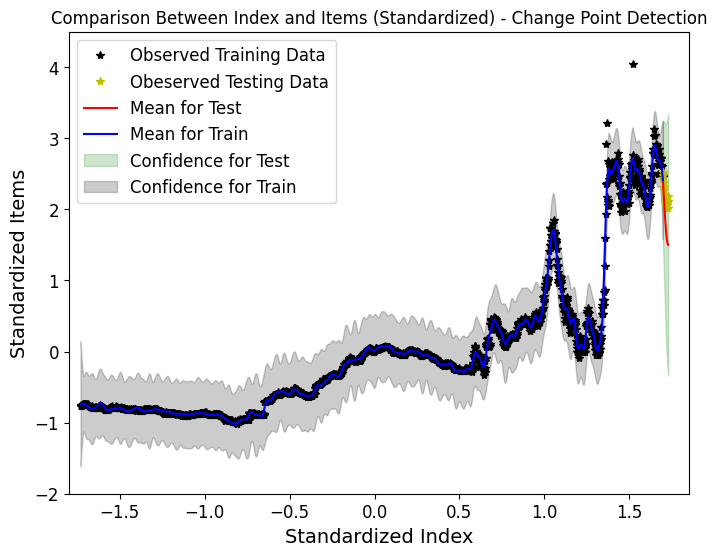

In [39]:
# Get into evaluation mode, or the predictive posterior mode
# Add the training and test metrics. Ex. MSE and MAE and CRPS. Test each individually.
# These tests have been incorporated as functions into the GPModel Class

model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    # Making predictions
    
    pred_train = likelihood(model(x_train))
    pred_test = likelihood(model(x_test))
    
    # Setting up the train_mean and test_mean so they can be used for some of the later tests.
    train_mean = pred_train.mean.numpy()
    test_mean = pred_test.mean.numpy()

    
    # Concatenate x_train and x_test together to get all data points for aid in calculating the variances.
    all_data = torch.cat([x_train, x_test], dim=0)

    # Get predictions and variances for all data points
    with torch.no_grad(), gp.settings.fast_pred_var():
        pred_all = likelihood(model(all_data))

    # Extract the variances for test and train data
    train_var = pred_all.variance[:len(x_train)]  # Variances for training data
    test_var = pred_all.variance[len(x_train):]   # Variances for test data


    # Initializing the plot
    fig3, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Getting the upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    lower_2, upper_2 = pred_test.confidence_region()
    
    # Plotting training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test.numpy(), 'y*')

    
    # Plotting predictive means as blue line
    ax.plot(x_test.numpy(), pred_test.mean.numpy(), 'r') # For test
    ax.plot(x_train.numpy(), pred_train.mean.numpy(), 'b') # For train
    
    import matplotlib.patches as patches

    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha = 0.2, color='green')
    ax.fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')

    
    #ax.set_ylim([0.75, 4.3])
    #ax.set_xlim([1.65, 1.73])
    
    ax.set_ylim([-2, 4.5])
    ax.set_xlim([-1.8, 1.85])
    
    # Adding a title to the graph
    ax.set_title('Comparison Between Index and Items (Standardized) - Change Point Detection')

    # Adding labels for the x and y axes
    ax.set_xlabel('Standardized Index', fontsize=14)
    ax.set_ylabel('Standardized Items', fontsize = 14)
    ax.tick_params(axis='both', labelsize=12)

    
    # plt.fit()
    ax.legend(['Observed Training Data', 'Obeserved Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train', 'Confidence for Test'], fontsize = 12)
    plt.show()


In [40]:

# Subplot 3 (zoomed out)
axs[2].plot(x_train.numpy(), y_train.numpy(), 'k*')
axs[2].plot(x_test.numpy(), y_test.numpy(), 'y*')
axs[2].plot(x_test.numpy(), pred_test.mean.numpy(), 'r')
axs[2].plot(x_train.numpy(), pred_train.mean.numpy(), 'b')
lower, upper = pred_train.confidence_region()
lower_2, upper_2 = pred_test.confidence_region()
axs[2].fill_between(x_test.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.2, color='green')
axs[2].fill_between(x_train.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, color='black')
axs[2].set_ylim([-2, 4.5])
#axs[2].set_xlim([-1.8, 1.85])
axs[2].set_xlim([0, 1.75])
axs[2].set_xlabel('Standardized Index', fontsize=40)
#axs[1].set_xticklabels([])
axs[2].set_yticklabels([])
# axs[2].set_ylabel('Standardized Items', fontsize = 14)
axs[2].set_title('FKC + Changepoint Detection', fontsize=42)
# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.tight_layout(pad=2.0)


<Figure size 1200x800 with 0 Axes>

In [41]:
'''
# Subplot 3: Change Point Detection (zoomed in)
lower_3, upper_3 = pred_train.confidence_region()
lower_4, upper_4 = pred_test.confidence_region()
#ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
#ax.plot(x_test.numpy(), y_test.numpy(), 'y*')
x_combined = torch.cat([x_test, x_train], dim=0)
mean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)
axs.plot(x_combined.numpy(), mean_combined.numpy(), 'k')
#axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'k')
#axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'k')
axs.fill_between(x_test.numpy(), lower_4.numpy(), upper_4.numpy(), alpha=0.2, color='purple')
axs.fill_between(x_train.numpy(), lower_3.numpy(), upper_3.numpy(), alpha=0.2, color='red')
'''

"\n# Subplot 3: Change Point Detection (zoomed in)\nlower_3, upper_3 = pred_train.confidence_region()\nlower_4, upper_4 = pred_test.confidence_region()\n#ax.plot(x_train.numpy(), y_train.numpy(), 'k*')\n#ax.plot(x_test.numpy(), y_test.numpy(), 'y*')\nx_combined = torch.cat([x_test, x_train], dim=0)\nmean_combined = torch.cat([pred_test.mean, pred_train.mean], dim=0)\naxs.plot(x_combined.numpy(), mean_combined.numpy(), 'k')\n#axs.plot(x_test.numpy(), pred_test.mean.numpy(), 'k')\n#axs.plot(x_train.numpy(), pred_train.mean.numpy(), 'k')\naxs.fill_between(x_test.numpy(), lower_4.numpy(), upper_4.numpy(), alpha=0.2, color='purple')\naxs.fill_between(x_train.numpy(), lower_3.numpy(), upper_3.numpy(), alpha=0.2, color='red')\n"

# Evaluation for ChangePoint Testing
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [42]:
from sts.metrics import MAE
MAE_train = MAE(y_train, pred_train.mean).item()
MAE_test = MAE(y_test, pred_test.mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.032
Mean absolute error for test set is: 0.341


In [43]:
!wget https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
from metrics import crps_gaussian
pred_train, pred_test = pred_train.mean.numpy(), pred_test.mean.numpy() # To work for the crps test.
crps_train = crps_gaussian(y_train, pred_train, train_var.sqrt())
crps_test = crps_gaussian(y_test, pred_test, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

--2024-01-11 04:06:51--  https://raw.githubusercontent.com/jpchen/autoforecasting/master/sts/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8399 (8.2K) [text/plain]
Saving to: ‘metrics.py.721’

metrics.py.721      100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-01-11 04:06:51 (48.3 MB/s) - ‘metrics.py.721’ saved [8399/8399]

Continuous ranked probability score for training set is: 0.061
Continuous ranked probability score for test set is: 0.232


In [44]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, pred_train, train_var).item()
ll_test = log_likelihood_error(test_mean, pred_test, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: 0.534
Log-likelihood for test set is: -0.522


/opt/conda/lib/python3.7/site-packages/sts/metrics.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -0.5 * torch.log(torch.tensor(2 * math.pi * var)).mean()


In [45]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_measure = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_measure

,MAE,CPRS,LL
0,0.032452,0.061227,0.533551
1,0.341172,0.231600,-0.522192


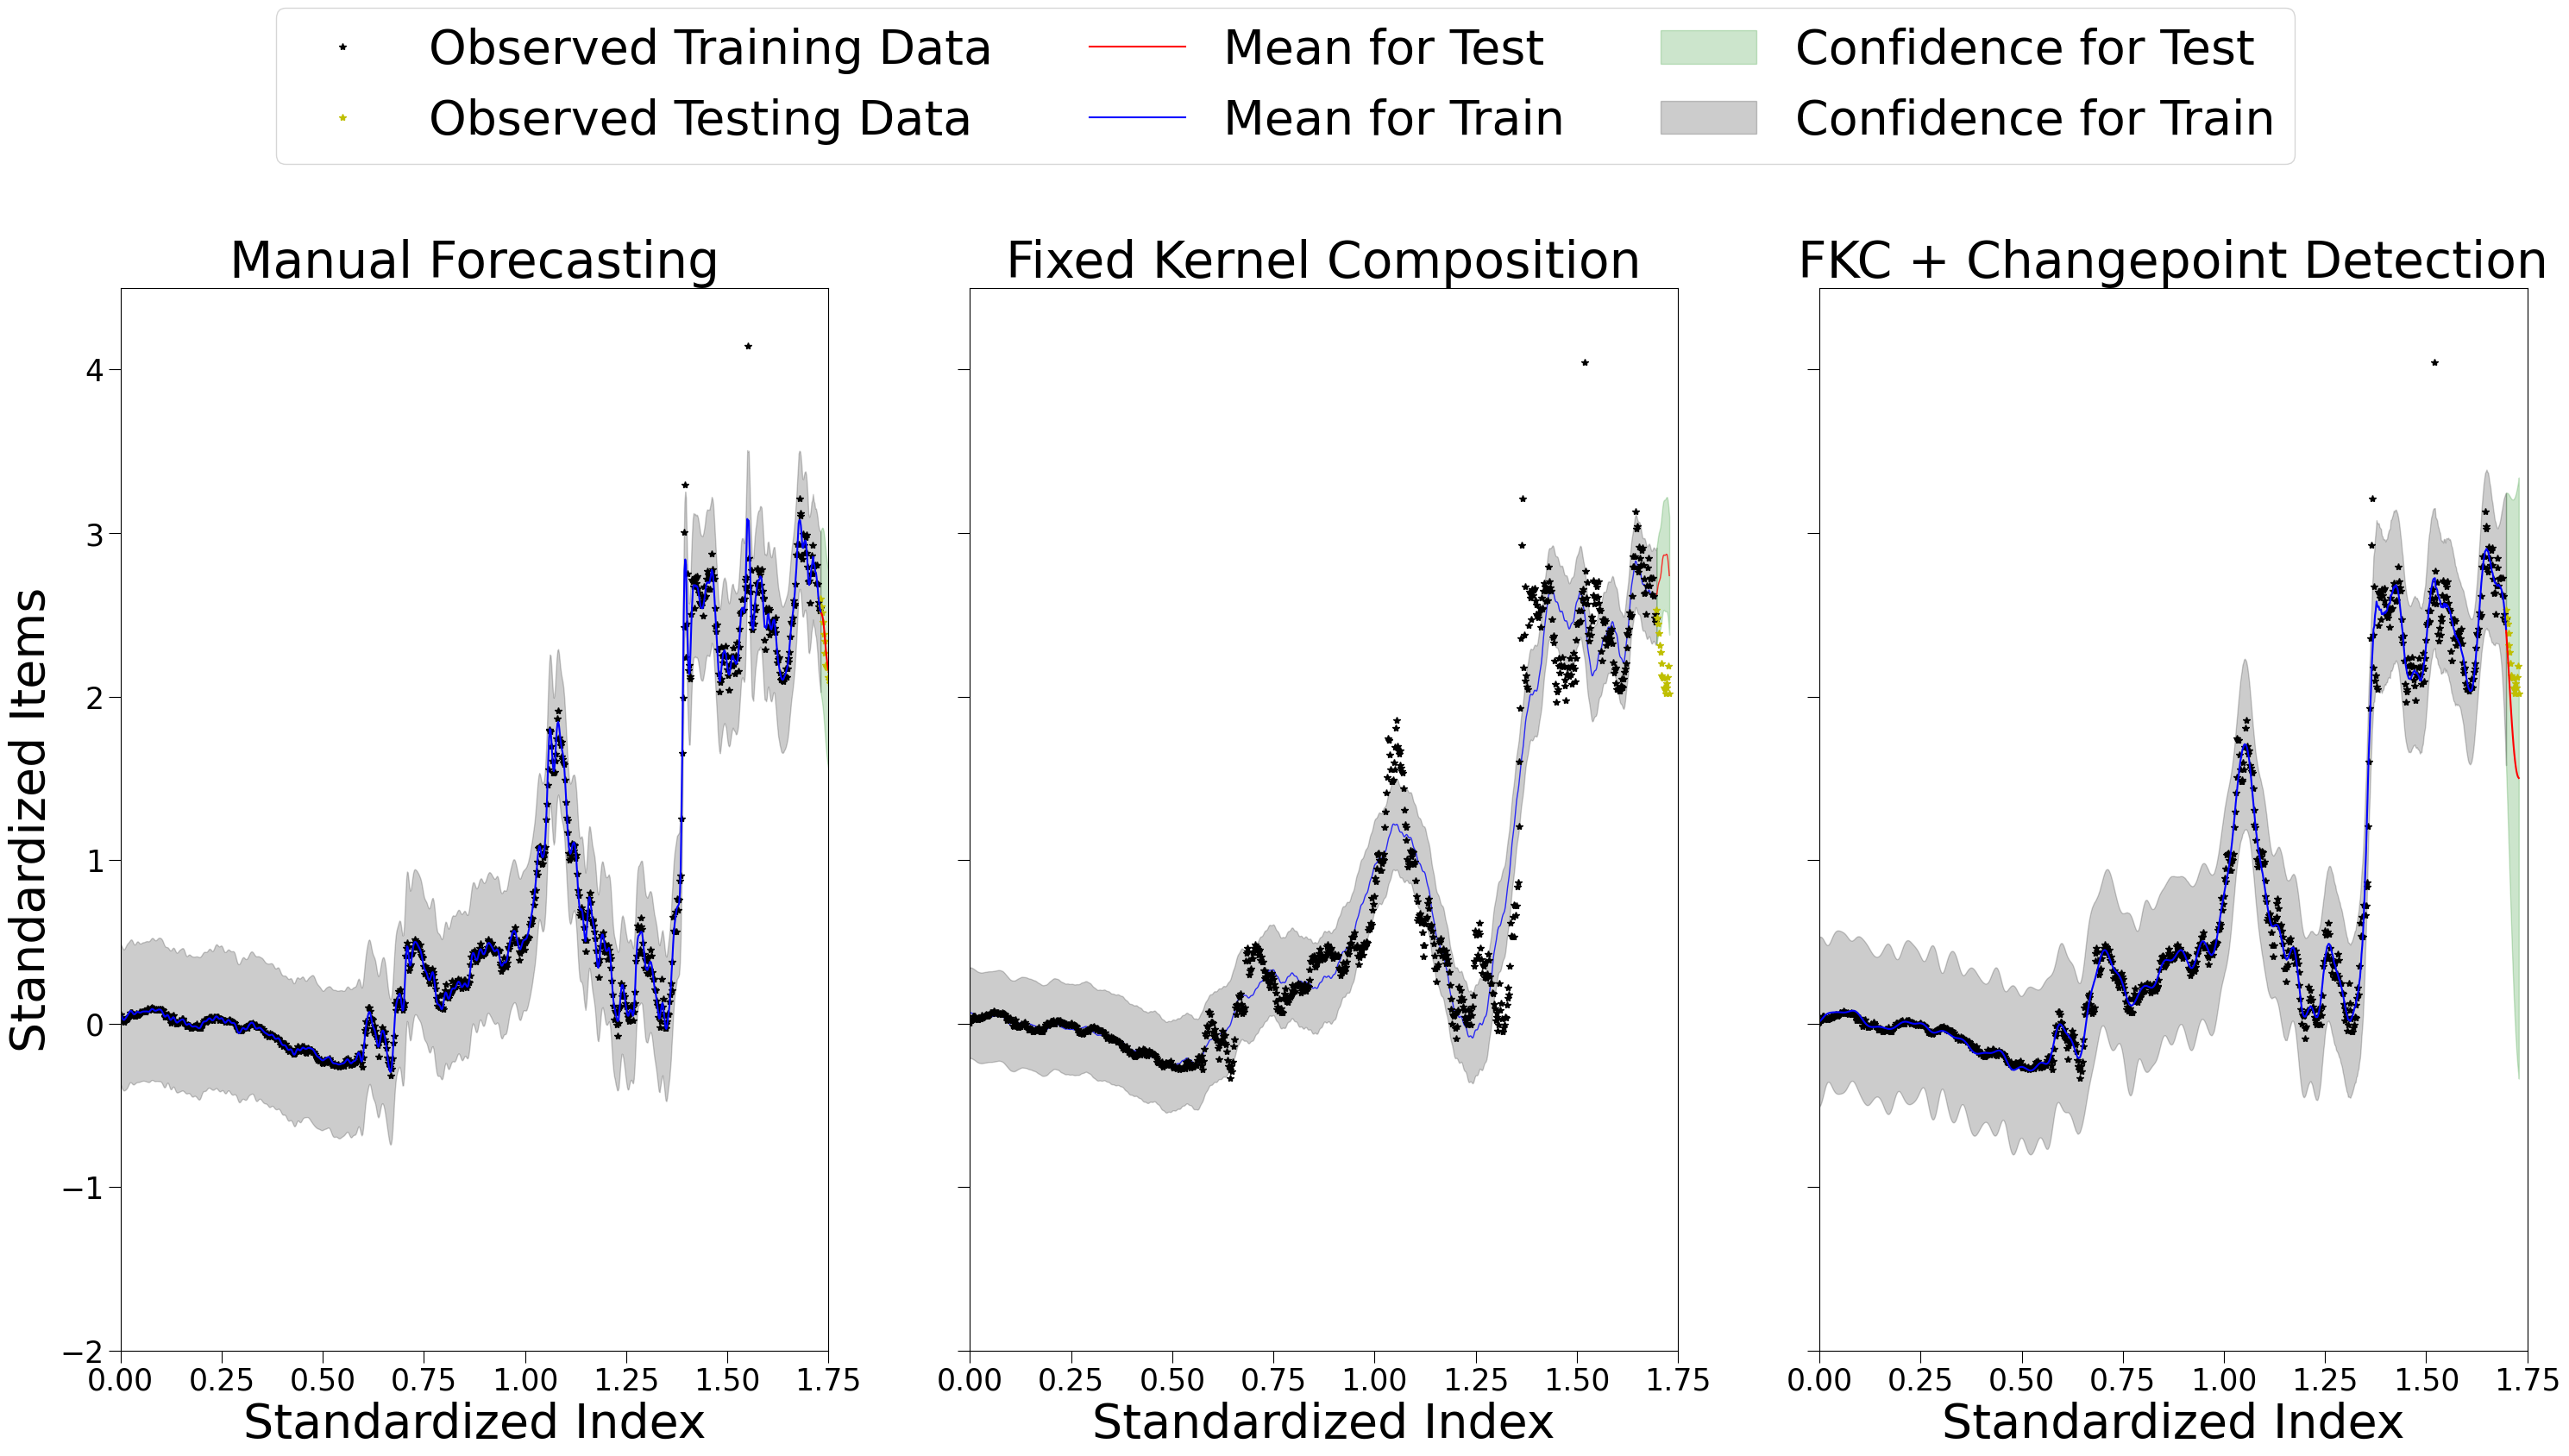

In [46]:
for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=25, length=10)
# Display the combined figure for the zoomed out figures.
fig.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test', 'Mean for Train', 'Confidence for Test', 'Confidence for Train'], fontsize=40, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
display(fig)
# Change to 0.95 instead of 1.05 for vertical.

In [47]:
'''
# Display the combined figure for the zoomed in visuals.
axs.set_ylim([0.75, 4.3])
axs.set_xlim([1.65, 1.73])
axs.set_title('Comparison Between Index and Items (Standardized)')
axs.set_xlabel('Standardized Index', fontsize=14)
axs.set_ylabel('Standardized Items', fontsize=14)
axs.tick_params(axis='both', labelsize=12)

#axs.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test (Manual)', 'Mean for Train (Manual)', 'Confidence for Test (Manual)', 'Confidence for Train (Manual)', 
#            'Mean for Train (Fixed)', 'Mean for Test (Fixed)', 'Confidence for Train (Fixed)', 'Confidence for Test (Fixed)',
#            'Mean for Test (Change Point)', 'Mean for Train (Change Point)', 'Confidence for Test (Change Point)', 'Confidence for Train (Change Point)'], fontsize=10)

axs.legend(['Observed Training Data', 'Observed Testing Data', 'Mean (Manual)', 'Confidence for Test (Manual)', 'Confidence for Train (Manual)', 
            'Mean (FKC)', 'Confidence for Train (FKC)', 'Confidence for Test (FKC)',
            'Mean (Change Point)', 'Confidence for Test (Change Point)', 'Confidence for Train (Change Point)'], fontsize=10)
# Show the combined plot
display(fig)
'''

"\n# Display the combined figure for the zoomed in visuals.\naxs.set_ylim([0.75, 4.3])\naxs.set_xlim([1.65, 1.73])\naxs.set_title('Comparison Between Index and Items (Standardized)')\naxs.set_xlabel('Standardized Index', fontsize=14)\naxs.set_ylabel('Standardized Items', fontsize=14)\naxs.tick_params(axis='both', labelsize=12)\n\n#axs.legend(['Observed Training Data', 'Observed Testing Data', 'Mean for Test (Manual)', 'Mean for Train (Manual)', 'Confidence for Test (Manual)', 'Confidence for Train (Manual)', \n#            'Mean for Train (Fixed)', 'Mean for Test (Fixed)', 'Confidence for Train (Fixed)', 'Confidence for Test (Fixed)',\n#            'Mean for Test (Change Point)', 'Mean for Train (Change Point)', 'Confidence for Test (Change Point)', 'Confidence for Train (Change Point)'], fontsize=10)\n\naxs.legend(['Observed Training Data', 'Observed Testing Data', 'Mean (Manual)', 'Confidence for Test (Manual)', 'Confidence for Train (Manual)', \n            'Mean (FKC)', 'Confidence

# References

[1] Corani, G., Benavoli, A., Augusto, J. and Zaffalon, M., 2020. Automatic Forecasting using Gaussian Processes. arXiv preprint arXiv:2009.08102.